In [118]:
import os
import wave
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import librosa
import librosa.display
import soundfile
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner
from keras.utils import plot_model
import tpot
from tqdm import tqdm

Let's set some parameters:

In [119]:
seed = 12345
dir_source = os.path.abspath('../data/recordings')
dir_trimmed = os.path.abspath('../data/trimmed')
dir_unified = os.path.abspath('../data/unified')
dir_mfcc = os.path.abspath('../data/mfcc/')

Let's collect names of all source files:

In [4]:
print('Source directory: ' + dir_source)
files_wav = os.listdir(dir_source)
print('Source files: ' + str(len(files_wav)))

Source directory: /Users/dmitry/Documents/Clemson/AML/project/data/recordings
Source files: 3000


The first step would be unify the number of channels.
Let's understand if it's required for our dataset:

In [120]:
ch = []
for fname in tqdm(files_wav):
    f = wave.open(dir_source + '/' + fname, 'rb')
    ch.append(f.getnchannels())
    f.close()
print('Unique channel number: ' + str(len(set(ch))))

100%|██████████| 3000/3000 [00:01<00:00, 2642.72it/s]

Unique channel number: 1


Let's understand how many channels our files have:

In [121]:
f = wave.open(dir_source + '/' + files_wav[0], 'rb')
print('Channels: ' + str(f.getnchannels()))
f.close()

Channels: 1


It means all our files have one channel (mono). For different numbers of channels we would have two options:
- downscale a number of channels for all files to 1
- upscale a number of channels for all files to the maximum of all files

The first option is simpler as for the second one we would need to handle the situation when the maximum is 3, but some files have 2 channels with different content.

The second step would be unify the sample rate.
Let's understand if it's required for our dataset:

In [122]:
rt = []
for fname in tqdm(files_wav):
    f = wave.open(dir_source + '/' + fname, 'rb')
    rt.append(f.getframerate())
    f.close()
print('Unique sample rate number: ' + str(len(set(rt))))

100%|██████████| 3000/3000 [00:01<00:00, 2769.06it/s]

Unique sample rate number: 1


In [123]:
print('Sample rate: ' + str(rt[0]))

Sample rate: 8000


The third step is to unify the duration.
As we have just mono files, we can calulate a duration for each file in the next way and understand if we need to unify it:

In [124]:
dur = []
for fname in tqdm(files_wav):
    f = wave.open(dir_source + '/' + fname, 'rb')
    dur.append(f.getnframes() / float(f.getframerate()))
    f.close()
print('Unique duration number: ' + str(len(set(dur))))

100%|██████████| 3000/3000 [00:00<00:00, 12846.92it/s]

Unique duration number: 2056


It means we need to unify the duration for all files.

Let's start with removing silence from all files:

In [125]:
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_source + '/' + fname, sr = 8000, mono = True)
    clip = librosa.effects.trim(audio, top_db = 10)
    soundfile.write(dir_trimmed + '/' + fname, clip[0], sr)

100%|██████████| 3000/3000 [00:04<00:00, 644.18it/s]


Now let's find the maximum duration among all files:

In [126]:
dur_max = 0
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_trimmed + '/' + fname, sr = 8000, mono = True)
    dur_max = dur_max if dur_max > audio.shape[0] else audio.shape[0]
print('Max duration: ' + str(dur_max))

100%|██████████| 3000/3000 [00:00<00:00, 4494.43it/s]

Max duration: 6457


And now let's unify duration for all files:

In [127]:
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_trimmed + '/' + fname, sr = 8000, mono = True)
    clip = librosa.util.pad_center(data = audio, size = dur_max)
    soundfile.write(dir_unified + '/' + fname, clip, sr)

100%|██████████| 3000/3000 [00:03<00:00, 909.99it/s] 


Let's calculate and normalize MFCCs:

In [129]:
scaler = sklearn.preprocessing.StandardScaler()
mfccs_tmp = []
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_unified + '/' + fname, sr = 8000, mono = True)
    mfcc = librosa.feature.mfcc(audio, sr = sr)
    mfccs_tmp.append(mfcc)

num_instances, num_time_steps, num_features = np.shape(mfccs_tmp)
mfccs_tmp = np.reshape(mfccs_tmp, newshape = (-1, num_features))
mfccs_tmp = scaler.fit_transform(mfccs_tmp)
mfccs_tmp = np.reshape(mfccs_tmp, newshape = (num_instances, num_time_steps, num_features))

for idx, item in enumerate(files_wav):
    np.savetxt(dir_mfcc + '/' + item.replace('.wav', '.mfcc'), mfccs_tmp[idx])

100%|██████████| 3000/3000 [00:21<00:00, 137.27it/s]


Let's split the dataset onto a training and a testing sets:

In [130]:
data_train, data_test = sklearn.model_selection.train_test_split(files_wav, random_state = seed)
print('Training set size: ' + str(len(data_train)))
print('Testing set size: ' + str(len(data_test)))

Training set size: 2250
Testing set size: 750


Let's create labels for our training and testing data:

In [131]:
data_train_label = []
data_test_label = []
for d in tqdm(data_train):
    data_train_label.append(d[0])
for d in tqdm(data_test):
    data_test_label.append(d[0])

100%|██████████| 750/750 [00:00<00:00, 623410.23it/s]


When we use sklearn for SVM, the library provides 3 options of implementation: SVC, NuSVC and LinearSVC. The latter is, actually, not truly SVM as it minimizes squared hinge loss, instead of just hinge loss, that leads to penalizing the size of bias, and supports only linear kernels, so, effectively, there are 2 options - SVC and NuSVC. As the both implementations are almost identical, we will use SVC.

In [132]:
mfccs_train = []
for fname in tqdm(data_train):
    mfccs_train.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')).ravel())
model_svm = sklearn.svm.SVC(kernel = 'rbf', random_state = seed)
model_svm.fit(mfccs_train, data_train_label)

mfccs_test = []
for fname in tqdm(data_test):
    mfccs_test.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')).ravel())
model_svm_predict =  model_svm.predict(mfccs_test)


100%|██████████| 750/750 [00:00<00:00, 2141.49it/s]


Let's build a confusion matrix for our model:

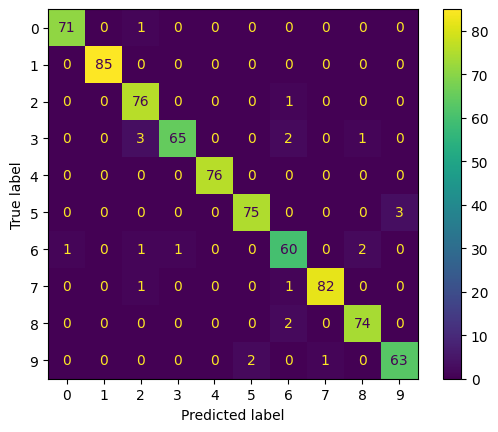

SVM accuracy with guesses on hyperparameters: 0.9693333333333334


In [133]:
conf_svm = sklearn.metrics.confusion_matrix(data_test_label, model_svm_predict);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_svm)
disp.plot()
plt.show()
accuracy_svm = sklearn.metrics.accuracy_score(data_test_label, model_svm_predict)
print('SVM accuracy with guesses on hyperparameters: ' + str(accuracy_svm))

Let's try to tune hyperparameters and enable K-fold cross-validation:

In [134]:
mfccs_train = []
for fname in tqdm(data_train):
    mfccs_train.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')).ravel())

model_svm_tuning_grid = dict(
    kernel = ['linear', 'rbf', 'sigmoid', 'poly'],
    C = range(1, 11, 1),
    degree = range(11),
    gamma = ['scale', 'auto']
)
model_svm_tuning_cv = sklearn.model_selection.RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = seed)
gridSearch = sklearn.model_selection.RandomizedSearchCV(estimator = sklearn.svm.SVC(), param_distributions = model_svm_tuning_grid, n_iter = 50, 
    n_jobs = -1, random_state = seed, cv = model_svm_tuning_cv, scoring = "accuracy", verbose = 3)
searchResults = gridSearch.fit(mfccs_train, data_train_label)
model_svm = searchResults.best_estimator_
print('The best model: ' + str(model_svm))

mfccs_test = []
for fname in tqdm(data_test):
    mfccs_test.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')).ravel())
model_svm_predict = model_svm.predict(mfccs_test)

100%|██████████| 2250/2250 [00:01<00:00, 1298.32it/s]


Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 5/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.984 total time=   0.3s
[CV 2/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.993 total time=   0.3s
[CV 3/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.993 total time=   0.3s
[CV 4/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.982 total time=   0.3s
[CV 1/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.984 total time=   0.3s
[CV 6/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.984 total time=   0.3s
[CV 7/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.987 total time=   0.2s
[CV 8/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.991 total time=   0.2s
[CV 13/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.987 total time=   0.2s
[CV 9/15] END C=5, degree=8, gamma=scale, kernel=linear;, score=0.991 total time=   0.2s
[CV 14/15] END C=5, degree=8, gamma=scale, ker

100%|██████████| 750/750 [00:00<00:00, 2351.87it/s]


Let's build a confusion matrix for our model:

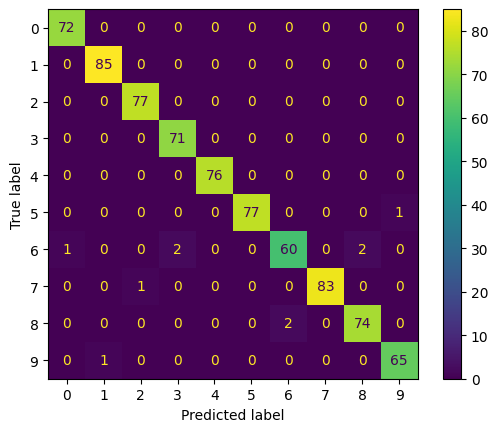

SVM accuracy with hyperparameters tuning and CV: 0.9866666666666667


In [135]:
conf_svm = sklearn.metrics.confusion_matrix(data_test_label, model_svm_predict);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_svm)
disp.plot()
plt.show()
accuracy_svm = sklearn.metrics.accuracy_score(data_test_label, model_svm_predict)
print('SVM accuracy with hyperparameters tuning and CV: ' + str(accuracy_svm))

Let's build CNN:

In [148]:
mfccs_train = []
for fname in tqdm(data_train):
    mfccs_train.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')))

mfccs_test = []
for fname in tqdm(data_test):
    mfccs_test.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')))

input_shape = (20, 13)
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Conv1D(filters = 20, kernel_size = 3, activation = 'relu', input_shape = input_shape))
model_cnn.add(tf.keras.layers.MaxPool1D(2))
model_cnn.add(tf.keras.layers.Dropout(0.2))
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
model_cnn.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
model_cnn_history = model_cnn.fit(np.array(mfccs_train), np.array([int(s) for s in data_train_label]), epochs = 20)
model_cnn_predict = model_cnn.predict(np.array(mfccs_test))

100%|██████████| 750/750 [00:00<00:00, 3271.69it/s]


Epoch 1/20
71/71 [==============================] - 1s 2ms/step - loss: 2.1970 - accuracy: 0.2204
Epoch 2/20
71/71 [==============================] - 0s 2ms/step - loss: 1.6936 - accuracy: 0.4787
Epoch 3/20
71/71 [==============================] - 0s 2ms/step - loss: 1.2620 - accuracy: 0.6569
Epoch 4/20
71/71 [==============================] - 0s 2ms/step - loss: 0.9349 - accuracy: 0.7556
Epoch 5/20
71/71 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.8164
Epoch 6/20
71/71 [==============================] - 0s 3ms/step - loss: 0.6027 - accuracy: 0.8444
Epoch 7/20
71/71 [==============================] - 0s 3ms/step - loss: 0.5066 - accuracy: 0.8662
Epoch 8/20
71/71 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.8844
Epoch 9/20
71/71 [==============================] - 0s 3ms/step - loss: 0.3937 - accuracy: 0.8991
Epoch 10/20
71/71 [==============================] - 0s 3ms/step - loss: 0.3525 - accuracy: 0.9071
Epoch 11/20
71/71 [

Let's build a confusion matrix for our model:

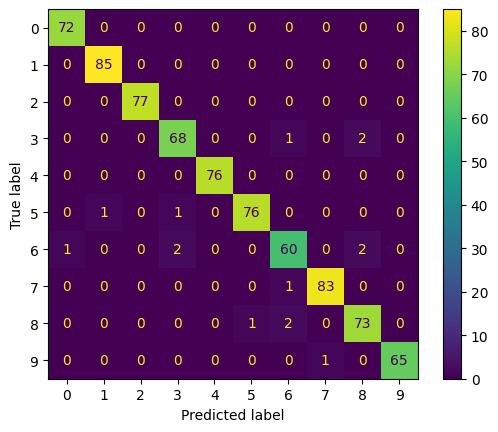

CNN accuracy: 0.98


In [149]:
conf_cnn = sklearn.metrics.confusion_matrix(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_cnn_predict]);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_cnn)
disp.plot()
plt.show()
accuracy_cnn = sklearn.metrics.accuracy_score(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_cnn_predict])
print('CNN accuracy: ' + str(accuracy_cnn))

Let's build optimized CNN:

In [150]:
def cnn_builder(tuner):
    model = tf.keras.models.Sequential()
    for i in range(1, tuner.Int("layers", 1, 3)):
        model.add(
            tf.keras.layers.Conv1D(
                filters = tuner.Int(f'filters_{i}', min_value = 4, max_value = 64, step = 4), 
                kernel_size = tuner.Int(f'kernel_size_{i}', min_value = 1, max_value = 5, step = 1), 
                activation = tuner.Choice(f'activation_{i}', ['relu', 'sigmoid', 'tanh']), 
                input_shape = (20, 13)
            )
        )
    model.add(tf.keras.layers.MaxPool1D(tuner.Int('pool', min_value = 1, max_value = 5, step = 1)))
    model.add(tf.keras.layers.Dropout(tuner.Float('dropout', min_value = 0.1, max_value = 0.9, step = 0.1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = tuner.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = ["accuracy"]
    )
    return model

tuner = keras_tuner.Hyperband(
    cnn_builder, 
    objective = 'val_accuracy', 
    seed = seed,
    overwrite = True,
    max_epochs = 20,
    hyperband_iterations = 3,
    directory = '../tuner', 
    project_name = 'cnn'
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5)
tuner.search(np.array(mfccs_train), np.array([int(s) for s in data_train_label]), epochs = 20, validation_split = 0.2, callbacks = [stop_early], verbose = 1)

model_cnn = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
model_cnn_history = model_cnn.fit(np.array(mfccs_train), np.array([int(s) for s in data_train_label]), epochs = 20)
model_cnn_predict = model_cnn.predict(np.array(mfccs_test))

Trial 90 Complete [00h 00m 05s]
val_accuracy: 0.4422222077846527

Best val_accuracy So Far: 0.9911110997200012
Total elapsed time: 00h 04m 07s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
71/71 [==============================] - 1s 2ms/step - loss: 0.7788 - accuracy: 0.7702
Epoch 2/20
71/71 [==============================] - 0s 2ms/step - loss: 0.1417 - accuracy: 0.9684
Epoch 3/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.9804
Epoch 4/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.9840
Epoch 5/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0592 - accuracy: 0.9884
Epoch 6/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9893
Epoch 7/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0430 - accuracy: 0.9876
Epoch 8/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9907
Epoch 9/20
71/71 [=================

In [151]:
print('The best CNN model:\n')
print(model_cnn.summary())

The best CNN model:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 16, 32)            2112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 32)             0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 4,682
Trainable params: 4,682
Non-trainable params: 0
_______________________________

In [153]:
print(model_cnn.get_layer('dropout_1').rate)

0.2


Let's build a confusion matrix for our model:

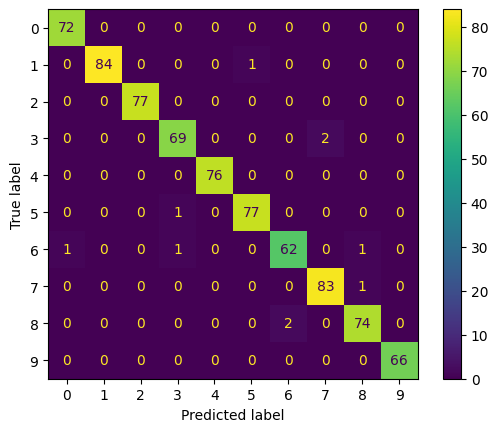

Optimized CNN accuracy: 0.9866666666666667


In [152]:
conf_cnn = sklearn.metrics.confusion_matrix(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_cnn_predict]);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_cnn)
disp.plot()
plt.show()
accuracy_cnn = sklearn.metrics.accuracy_score(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_cnn_predict])
print('Optimized CNN accuracy: ' + str(accuracy_cnn))

Let's create RNN:

In [162]:
input_shape = (20, 13)
model_rnn = tf.keras.models.Sequential()
model_rnn.add(tf.keras.layers.SimpleRNN(48, input_shape = input_shape, return_sequences = True))
model_rnn.add(tf.keras.layers.Dropout(0.2))
model_rnn.add(tf.keras.layers.SimpleRNN(32))
model_rnn.add(tf.keras.layers.Dropout(0.2))
model_rnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
model_rnn.compile(optimizer = 'adam',loss = 'SparseCategoricalCrossentropy', metrics = ['acc'])
model_rnn_history = model_rnn.fit(np.array(mfccs_train), np.array([int(s) for s in data_train_label]), epochs = 20)
model_rnn_predict = model_rnn.predict(np.array(mfccs_test))

Epoch 1/20
71/71 [==============================] - 2s 7ms/step - loss: 1.8019 - acc: 0.4142
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 0.9209 - acc: 0.7858
Epoch 3/20
71/71 [==============================] - 0s 6ms/step - loss: 0.5434 - acc: 0.8964
Epoch 4/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3473 - acc: 0.9431
Epoch 5/20
71/71 [==============================] - 1s 8ms/step - loss: 0.2657 - acc: 0.9413
Epoch 6/20
71/71 [==============================] - 1s 7ms/step - loss: 0.2086 - acc: 0.9547
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1611 - acc: 0.9676
Epoch 8/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1355 - acc: 0.9720
Epoch 9/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1283 - acc: 0.9684
Epoch 10/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1186 - acc: 0.9711
Epoch 11/20
71/71 [==============================] - 0s 6ms/step - lo

Let's build a confusion matrix for our model:

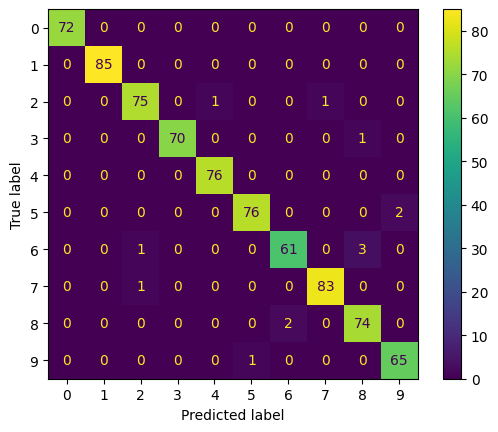

RNN accuracy: 0.9826666666666667


In [163]:
conf_rnn = sklearn.metrics.confusion_matrix(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_rnn_predict]);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_rnn)
disp.plot()
plt.show()
accuracy_rnn = sklearn.metrics.accuracy_score(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_rnn_predict])
print('RNN accuracy: ' + str(accuracy_rnn))

Let's build an optimized RNN:

In [168]:
def rnn_builder(tuner):
    model = tf.keras.models.Sequential()
    for i in range(1, tuner.Int("layers", min_value = 2, max_value = 4, step = 1)):
        model.add(
            tf.keras.layers.LSTM(
                name = f'simplernn_{i}',
                units = tuner.Int(f'filters_{i}', min_value = 4, max_value = 64, step = 4), 
                activation = tuner.Choice(f'activation_{i}', ['relu', 'sigmoid', 'tanh']),
                return_sequences = True,
                input_shape = (20, 13)
            )
        )
    model.add(tf.keras.layers.Dropout(tuner.Float(f'dropout_{i}', min_value = 0.1, max_value = 0.9, step = 0.1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = ["accuracy"]
    )
    return model

tuner = keras_tuner.Hyperband(
    cnn_builder, 
    objective = 'val_accuracy', 
    seed = seed,
    overwrite = True,
    max_epochs = 20,
    hyperband_iterations = 5,
    directory = '../tuner', 
    project_name = 'rnn'
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5)
tuner.search(np.array(mfccs_train), np.array([int(s) for s in data_train_label]), epochs = 20, validation_split = 0.2, callbacks = [stop_early], verbose = 1)

model_rnn = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
model_rnn_history = model_rnn.fit(np.array(mfccs_train), np.array([int(s) for s in data_train_label]), epochs = 20)
model_rnn_predict = model_rnn.predict(np.array(mfccs_test))


Trial 150 Complete [00h 00m 06s]
val_accuracy: 0.9622222185134888

Best val_accuracy So Far: 0.9911110997200012
Total elapsed time: 00h 06m 57s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
71/71 [==============================] - 1s 2ms/step - loss: 0.7924 - accuracy: 0.7569
Epoch 2/20
71/71 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9649
Epoch 3/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0939 - accuracy: 0.9764
Epoch 4/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9791
Epoch 5/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.9813
Epoch 6/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.9822
Epoch 7/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9858
Epoch 8/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9907
Epoch 9/20
71/71 [================

In [108]:
print('The best RNN model:\n')
print(model_rnn.summary())

The best RNN model:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simplernn_1 (LSTM)          (None, 20, 64)            19968     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 32,778
Trainable params: 32,778
Non-trainable params: 0
_________________________________________________________________
None


In [117]:
print(model_rnn.get_layer('simplernn_1').recurrent_initializer)

Let's build a confusion matrix for our model:

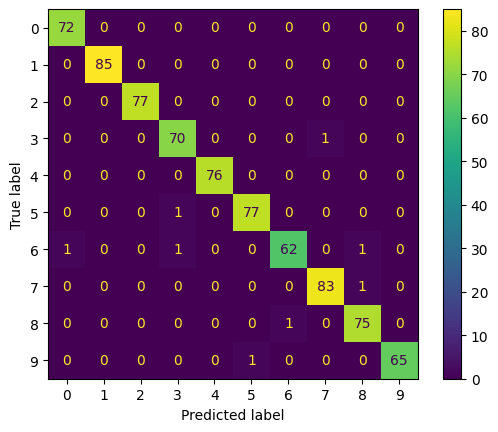

RNN accuracy: 0.9893333333333333


In [169]:
conf_rnn = sklearn.metrics.confusion_matrix(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_rnn_predict]);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_rnn)
disp.plot()
plt.show()
accuracy_rnn = sklearn.metrics.accuracy_score(data_test_label, [str(np.where(ar == max(ar))[0][0]) for ar in model_rnn_predict])
print('RNN accuracy: ' + str(accuracy_rnn))

Let's use AutoML to find a model:

In [32]:
model_aml_cv = sklearn.model_selection.RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = seed)
model_aml = tpot.TPOTClassifier(generations = 5, population_size = 50, cv = model_aml_cv, scoring = 'accuracy', verbosity = 2, random_state = seed, n_jobs = -1)
model_aml.fit(np.array(mfccs_train).reshape(2250, -1), np.array([int(s) for s in data_train_label]))
model_aml_predict = model_aml.predict(np.array(mfccs_test).reshape(750, -1))

                                                                                
Generation 1 - Current best internal CV score: 0.983111111111111
                                                                              
Generation 2 - Current best internal CV score: 0.9851851851851853
                                                                                
Generation 3 - Current best internal CV score: 0.9865185185185185
                                                                                
Generation 4 - Current best internal CV score: 0.9887407407407408
                                                             
Generation 5 - Current best internal CV score: 0.9887407407407408
                                                             
Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.2, min_samples_leaf=1, min_samples_split=4, n_estimators=100)


Let's build a confusion matrix for our model:

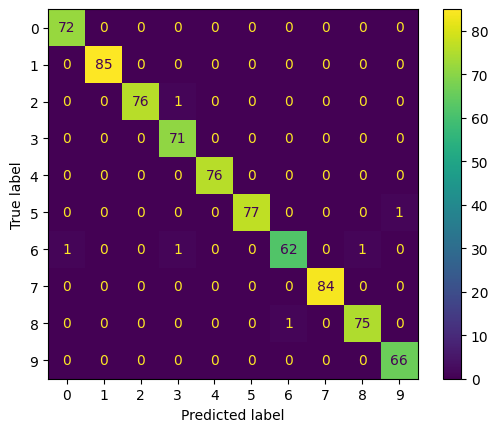

AutoML produced model accuracy: 0.992


In [33]:
conf_aml = sklearn.metrics.confusion_matrix(data_test_label, [str(ar) for ar in model_aml_predict]);
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_aml)
disp.plot()
plt.show()
accuracy_aml = sklearn.metrics.accuracy_score(data_test_label, [str(ar) for ar in model_aml_predict])
print('AutoML produced model accuracy: ' + str(accuracy_aml))